<a href="https://colab.research.google.com/github/lorenzhelle/Pneumonia/blob/master/Pneumonia3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

!pip install tensorflow==2.0.0



     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 450kB 57.0MB/s 
     |████████████████████████████████| 3.8MB 46.2MB/s 
     |████████████████████████████████| 81kB 13.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [0]:

import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


First extract the zip file which is located in the mounted google drive.

In [0]:

#local_zip = '/content/gdrive/My Drive/Data/pneumonia.zip'
local_zip = '/content/gdrive/My Drive/Data/PneumoniaNew2.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

Define a callback such that training stops as soon as 95% vailidation accuracy is achieved. 

In [0]:


class myCallback(tf.keras.callbacks.Callback):
  # on_epoch_end get called when epoch ends
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>=0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True



The model consists of 6 convolutional layers which are seperated by max pooling layers. After the last convolutional layer the output is flattened via a global average pooling layer. The convolutional layers are followed by 3 dense layers. The last dense layer has one neuron using the sigmoid activation function since we have a binary classifcation problem. We use the Adam optimizer and the binary cross entropy loss function.

In [0]:
callbacks = myCallback()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(80, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer=Adam(lr=0.00009, decay=1e-5), loss='binary_crossentropy', metrics=['acc'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 48)        1

The train generator uses image augmentation, specifically width shift, height shift, rotation and zoom. The image size is reduced to 150x150 pixels such that training speed is significantly increased. The jpeg images are also converted to grayscale without loss of any relvant information.
The validation generator does not use image augmentation.


In [0]:

batch_size=20
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1,
                                  rotation_range=20,
                                  zoom_range=0.2)

train_dir = "/tmp/train"
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='binary',
                                                    target_size=(150, 150))

val_datagen = ImageDataGenerator(rescale=1./255)
val_dir = "/tmp/val"
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                          batch_size=batch_size,
                                                          color_mode='grayscale',
                                                          class_mode='binary',
                                                          target_size=(150, 150))

test_dir = "/tmp/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  color_mode='grayscale',
                                                  class_mode='binary',
                                                  target_size=(150, 150),
                                                  shuffle=False)




Found 4678 images belonging to 2 classes.
Found 554 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We train the model with a batch size of 20 for 6 epochs. Due to the amount of training images one epoch takes almost 3 minutes to complete!

In [0]:
history = model.fit_generator(train_generator,
                              epochs=6,
                              verbose=1,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data = validation_generator, 
                              validation_steps = validation_generator.samples // batch_size,
                              callbacks=[callbacks])

Epoch 1/6
233/233 [==============================] - 193s 829ms/step - loss: 0.3555 - acc: 0.8482 - val_loss: 1.5788 - val_acc: 0.5296
Epoch 2/6
233/233 [==============================] - 194s 834ms/step - loss: 0.2305 - acc: 0.9094 - val_loss: 2.9243 - val_acc: 0.5296
Epoch 3/6
233/233 [==============================] - 192s 826ms/step - loss: 0.2195 - acc: 0.9105 - val_loss: 0.8896 - val_acc: 0.6796
Epoch 4/6
232/233 [============================>.] - ETA: 0s - loss: 0.1932 - acc: 0.9230
Reached 95% accuracy so cancelling training!
233/233 [==============================] - 193s 830ms/step - loss: 0.1929 - acc: 0.9231 - val_loss: 0.1562 - val_acc: 0.9537


We Define a function which plots the ROC curve to evaluate the performance of the model

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt  



def plot_roc_curve(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

We generate a ROC curve for the model and display the confusion matrix for the threshold of 50%. We specifically choose the final model such that Recall was very high. This is because in this kind of medical condition evaluation it is more important to have very few false negatives at the expensive of having some more false positives. 

Found 554 images belonging to 2 classes.
[[245  16]
 [  9 284]]
Recall of the model is 0.97
Precision of the model is 0.95


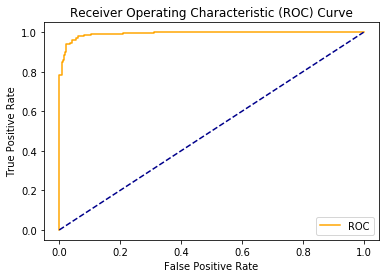

AUC of the model is 0.99


In [0]:

from sklearn.metrics import confusion_matrix


validation_generator2 = val_datagen.flow_from_directory(val_dir,
                                                              batch_size=16,
                                                              color_mode="grayscale",
                                                              class_mode='binary',
                                                              target_size=(150, 150),
                                                              shuffle=False)

probabilities = model.predict_generator(generator=validation_generator2)
#print(probabilities)
y_true = validation_generator2.classes
y_pred = probabilities > 0.5


mat = confusion_matrix(y_true, y_pred)
print(mat)

tn, fp, fn, tp = mat.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

fper, tper, thresholds = roc_curve(y_true, probabilities) 
plot_roc_curve(fper, tper)
AUC = roc_auc_score(y_true, probabilities)

print("AUC of the model is {:.2f}".format(round(AUC, 4)))



<Figure size 432x288 with 0 Axes>

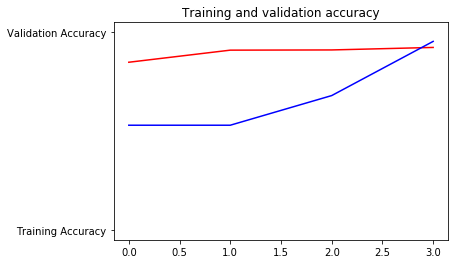

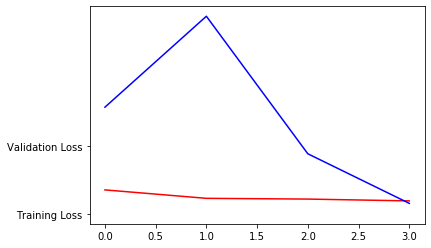

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

Finally we evaluate the choosen model with the never seen before test data. We find that the model performs only slightly worse than on the validation set for which we optimized. This suggest that the model generalized very well. The AUC value of 0.96 is also quite high.

In [0]:
probabilities = model.predict_generator(generator=test_generator)
#print(probabilities)
y_true = test_generator.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred)
print(mat)

tn, fp, fn, tp = mat.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

[[152  82]
 [  6 384]]
Recall of the model is 0.98
Precision of the model is 0.82


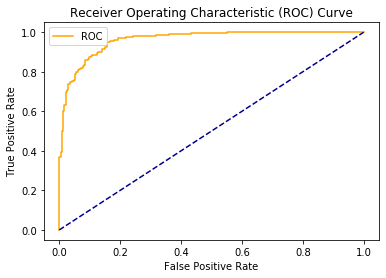

AUC of the model is 0.96


In [0]:


fper, tper, thresholds = roc_curve(y_true, probabilities) 
plot_roc_curve(fper, tper)
AUC = roc_auc_score(y_true, probabilities)

print("AUC of the model is {:.2f}".format(round(AUC, 4)))


